### Looking for global fit (standard GLM-HMM) for Psytrack animals all together

In [2]:
# importing packages and modules
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize
from utils import *
from plotting_utils import *
from analysis_utils import *
import dglm_hmm1
from scipy.stats import multivariate_normal, norm
# import jax

# code from summer project working with PWM data
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', '..', 'LC_PWM_GLM-HMM/code')))
import io_utils, analysis_utils, plotting_utils

sns.set_context("talk")

In [3]:
#  animalsIDs = ['W060','W068','W073','W074','W075','W080','W081','W082','W088','W089']
animalsIDs = ['W060','W075','W081','W089']
pni_path = '/Users/lencacuturela/Desktop/github/LC_PWM_GLM-HMM/data'
laptop_path = '/Users/lencacuturela/Desktop/Research/github/LC_PWM_GLM-HMM/data'

In [3]:
# According to Jonathan's suggestions for fitting global GLM-HMM for all animals
# stage filter changed from 3 to 4
# cutoff changed from 10 to 50
firstAnimal = 'W060'
x, y = io_utils.prepare_design_matrices(rat_id=firstAnimal, path=pni_path, psychometric=True, cutoff=100, stage_filter=4, overwrite=False)
sessInd = list(io_utils.session_start(rat_id=firstAnimal, path=pni_path, psychometric=True, cutoff=100, stage_filter=4))

for animal in animalsIDs:
    if (animal != firstAnimal):
        xTemp, yTemp = io_utils.prepare_design_matrices(rat_id=animal, path=pni_path, psychometric=True, cutoff=100, stage_filter=4, overwrite=False)
        sessIndTemp = list(io_utils.session_start(rat_id=animal, path=pni_path, psychometric=True, cutoff=100, stage_filter=4))
        x = np.concatenate((x,xTemp))
        y = np.concatenate((y,yTemp))
oneSessInd = [0,x.shape[0]]
print(oneSessInd)

# NOT TAKING INTO ACCOUNT TO BREAK FORWARD-BACKWARD AT EACH SESSION LIKE IRIS DOES
    

FileNotFoundError: [Errno 2] No such file or directory: '/Users/lencacuturela/Desktop/github/LC_PWM_GLM-HMM/data/rat_behavior.csv'

### K=1 GLM Fit

In [14]:
inits = 20
penaltyW=True
maxiter = 250

path = pni_path

N = x.shape[0]
D = x.shape[1]
C = 2 # only looking at binomial classes
K = 1

allP = np.zeros((inits, K, K))
allW = np.zeros((inits, N, K, D, C))
allLl = np.zeros((inits, maxiter))
testLl = np.zeros((inits))
oneSessInd = [0,N]
dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)

for i in range(0,inits):
    print("Init ", i)

    # global fit
    if (i%2 ==0):
        initP0, initW0 = dGLM_HMM.generate_param(sessInd=oneSessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-2,2)]) 
    else:
        initP0, initW0 = dGLM_HMM.generate_param(sessInd=oneSessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['normal', (0,2)]) 
    allP[i], allW[i], allLl[i] = dGLM_HMM.fit(x, y,  initP0, initW0, sigma=reshapeSigma(1, K, D), sessInd=oneSessInd, pi0=None, maxIter=maxiter, tol=1e-3, penaltyW=penaltyW) # sigma does not matter here
    
    np.save(f'../data_PWM/trainLl-global_PWM_all-animals_sf=4_{K}_state_multiple_inits_penaltyW={penaltyW}', allLl)
    np.save(f'../data_PWM/P-global_PWM_all-animals_sf=4_{K}_state_multiple_inits_penaltyW={penaltyW}', allP)
    np.save(f'../data_PWM/W-global_PWM_all-animals_sf=4_{K}_state_multiple_inits_penaltyW={penaltyW}', allW)

    

Init  0
0
Init  1
0
Init  2
0
Init  3
0
Init  4
0
Init  5
0
Init  6
0
Init  7
0
Init  8
0
Init  9
0


KeyboardInterrupt: 

In [9]:
K = 1
allW = np.load(f'../data_PWM/W-global_PWM_all-animals_sf=4_{K}_state_multiple_inits_L2penaltyW=1.npy')
weightsGLM = allW[0]
print(weightsGLM[10000,:,:,1])

[[-0.02367646 -1.3375472   1.71198048 -0.2121932  -0.08533615 -0.33284049]]


In [ ]:
# Find best init for GLM

#### K=2 GLM-HMM Fit with weight initializations from GLM + noise - 3 out of 6 options were top ones, same like Iris' global solutions

In [64]:
inits = 12
L2penaltyW=1
maxiter = 250

path = pni_path

N = x.shape[0]
D = x.shape[1]
C = 2 # only looking at binomial classes
K = 2

allP = np.zeros((inits, K, K))
allW = np.zeros((inits, N, K, D, C))
allLl = np.zeros((inits, maxiter))
testLl = np.zeros((inits))
oneSessInd = [0,N]
dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)

weightsGLM_K2 = np.repeat(weightsGLM, 2, axis=1)
for i in range(0,inits):
    print("Init ", i)
    # global fit
    if (i%2 ==0):
        initP, initW0 = dGLM_HMM.generate_param(sessInd=oneSessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-1,1)]) 
        initW = initW0 + weightsGLM_K2
    else:
        initP, initW0 = dGLM_HMM.generate_param(sessInd=oneSessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['normal', (0,1)]) 
        initW = initW0 + weightsGLM_K2
    allP[i], allW[i], allLl[i] = dGLM_HMM.fit(x, y,  initP, initW, sigma=reshapeSigma(1, K, D), sessInd=oneSessInd, pi0=None, maxIter=maxiter, tol=1e-3, penaltyW=penaltyW) # sigma does not matter here
    np.save(f'../data_PWM/trainLl-global_PWM_all-animals_sf=4_{K}_state_multiple_inits_L2penaltyW={L2penaltyW}', allLl)
    np.save(f'../data_PWM/P-global_PWM_all-animals_sf=4_{K}_state_multiple_inits_L2penaltyW={L2penaltyW}', allP)
    np.save(f'../data_PWM/W-global_PWM_all-animals_sf=4_{K}_state_multiple_inits_L2penaltyW={L2penaltyW}', allW)
    

    

Init  0
0
Init  1
0
100
200
Init  2
0
Init  3
0
Init  4
0
100
200
Init  5
0


KeyboardInterrupt: 

In [7]:
K = 1
allW = np.load(f'../data_PWM/W-global_PWM_all-animals_sf=3_{K}_state_multiple_inits_L2penaltyW=1')
print(allW.shape)
    

FileNotFoundError: [Errno 2] No such file or directory: '../data_PWM/W-global_PWM_all-animals_sf=3_1_state_multiple_inits_L2penaltyW=1'

### Per Animal global GLM-HMM fits

In [ ]:
# write function to find best GLM-HMM INITALIAATIONS for each animal

In [4]:
rat_id = 'W081'
animal = 'W081'
folds = 4
x, y = io_utils.prepare_design_matrices(rat_id=animal, path=laptop_path, psychometric=True, cutoff=10, stage_filter=3, overwrite=False)
sessInd = list(io_utils.session_start(rat_id=animal, path=laptop_path, psychometric=True, cutoff=10, stage_filter=3))

N = x.shape[0]
D = x.shape[1]
C = 2 # only looking at binomial classes
oneSessInd = [0,N]
maxiter=250
L2penaltyW = 1

# GLM FIT
K = 1
dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)
initP0, initW0 = dGLM_HMM.generate_param(sessInd=oneSessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-2,2)]) 
glmP, glmW, glmLl = dGLM_HMM.fit(x, y,  initP0, initW0, sigma=reshapeSigma(1, K, D), sessInd=oneSessInd, pi0=None, maxIter=maxiter, tol=1e-3, L2penaltyW=L2penaltyW) # sigma does not matter here
print(glmW[0,:,:,1])

# multiple initializations for GLM-HMM fit 
K = 2
inits = 9
allP = np.zeros((inits, K, K))
allW = np.zeros((inits, N, K, D, C))
allLl = np.zeros((inits, maxiter))
testLl = np.zeros((inits))
oneSessInd = [0,N]
dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)

weightsGLM_K2 = np.repeat(glmW, K, axis=1)
for i in range(0,inits):
    print("Init ", i)
    # global fit
    if (i%3 ==0):
        initP, initW0 = dGLM_HMM.generate_param(sessInd=oneSessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-1,1)]) 
        initW = initW0 + weightsGLM_K2
    elif (i%3==1):
        initP, initW0 = dGLM_HMM.generate_param(sessInd=oneSessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['normal', (0,1)]) 
        initW = initW0 + weightsGLM_K2
    else:
        initP, initW = dGLM_HMM.generate_param(sessInd=oneSessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-2,2)]) 
    allP[i], allW[i], allLl[i] = dGLM_HMM.fit(x, y,  initP, initW, sigma=reshapeSigma(1, K, D), sessInd=oneSessInd, pi0=None, maxIter=maxiter, tol=1e-3, L2penaltyW=L2penaltyW) # sigma does not matter here
    np.save(f'../data_PWM/trainLl-global_PWM_{rat_id}_sf=3_{K}_state_multiple_inits_L2penaltyW={L2penaltyW}', allLl)
    np.save(f'../data_PWM/P-global_PWM_{rat_id}_sf=3_{K}_state_multiple_inits_L2penaltyW={L2penaltyW}', allP)
    np.save(f'../data_PWM/W-global_PWM_{rat_id}_sf=3_{K}_state_multiple_inits_L2penaltyW={L2penaltyW}', allW)
    

0
[[-0.01319282 -0.9248255   1.35252077 -0.20752368 -0.174234   -0.41068782]]
Init  0
0
100
200
Init  1
0
100
200
Init  2
0
100
200
Init  3
0
100
200
Init  4
0
100
200
Init  5
0
Init  6
0
Init  7
0
100
200
Init  8
0


In [5]:
rat_id = 'W081'
K=2
L2penaltyW=1
allLl = np.load(f'../data_PWM/trainLl-global_PWM_{rat_id}_sf=3_{K}_state_multiple_inits_L2penaltyW={L2penaltyW}.npy')
allP = np.load(f'../data_PWM/P-global_PWM_{rat_id}_sf=3_{K}_state_multiple_inits_L2penaltyW={L2penaltyW}.npy')
allW = np.load(f'../data_PWM/W-global_PWM_{rat_id}_sf=3_{K}_state_multiple_inits_L2penaltyW={L2penaltyW}.npy')

[5 6 8]


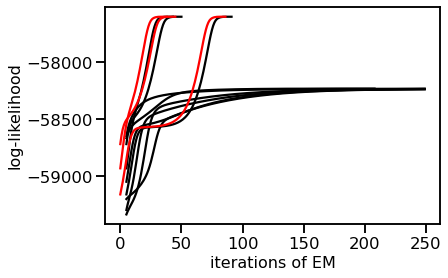

In [6]:
fig, axes = plt.subplots(1)
bestInd, finalLl, topInd = find_top_init_plot_loglikelihoods(allLl[0:9],maxdiff=0.2,ax=axes,startix=5,plot=True)
print(topInd)

In [17]:
animalsCurrent = ['W068','W075','W068','W081','W089']
for rat_id in animalsCurrent:
    path=laptop_path
    fold = 0
    stage_filter = 3
    folds = 4
    x, y = io_utils.prepare_design_matrices(rat_id=rat_id, path=path, psychometric=True, cutoff=10, stage_filter=stage_filter, overwrite=False)
    sessInd = list(io_utils.session_start(rat_id=rat_id, path=path, psychometric=True, cutoff=10, stage_filter=stage_filter)) 
    trainX, trainY, trainSessInd, testX, testY, testSessInd = split_data_per_session(x, y, sessInd, folds=folds, random_state=1)
    D = trainX[0].shape[1]
    C = 2 # only looking at binomial classes
    K = 2
    oldSessInd = [0, allW[2].shape[0]]
    testLlInit = np.zeros((9))
    N = trainX[fold].shape[0]
    dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)
    trainY[fold] = trainY[fold].astype(int)
    testY[fold] = testY[fold].astype(int)
    # evaluate
    for ind in range(0,9):
        sess = len(testSessInd[fold]) - 1 # number sessions
        testPhi = dGLM_HMM.observation_probability(testX[fold], reshapeWeights(allW[ind], oldSessInd, testSessInd[fold], True))
        for s in range(0, sess):
            # evaluate on test data for each session separately
            _, _, temp = dGLM_HMM.forward_pass(testY[fold][testSessInd[fold][s]:testSessInd[fold][s+1]],allP[ind],testPhi[testSessInd[fold][s]:testSessInd[fold][s+1]])
            testLlInit[ind] += temp

    testLlInit = testLlInit / testSessInd[fold][-1] # normalizing to the total number of trials in test dataset
    print(testLlInit)
    print(finalLl.shape)
    trainLlInit = finalLl 
    print(trainLlInit)

[-0.54446681 -0.54427411 -0.54926423 -0.54605246 -0.54926393 -0.54605491
 -0.54465972 -0.54435333 -0.54439957]
(9,)
[-72731.25843454 -72730.53100786 -72680.06840354 -72907.90030703
 -72680.06866169 -72907.82501329 -72733.56773941 -72733.59553102
 -72730.67522002]


In [19]:
print(allW[2])

[[[[ 0.         -0.03995084]
   [ 0.         -1.2224458 ]
   [ 0.          1.67129189]
   [ 0.         -0.23273413]
   [ 0.         -0.17079253]
   [ 0.         -0.32119218]]

  [[ 0.          0.04025063]
   [ 0.         -0.30774395]
   [ 0.          0.818934  ]
   [ 0.         -0.14915913]
   [ 0.         -0.50921711]
   [ 0.         -0.73993549]]]


 [[[ 0.         -0.03995084]
   [ 0.         -1.2224458 ]
   [ 0.          1.67129189]
   [ 0.         -0.23273413]
   [ 0.         -0.17079253]
   [ 0.         -0.32119218]]

  [[ 0.          0.04025063]
   [ 0.         -0.30774395]
   [ 0.          0.818934  ]
   [ 0.         -0.14915913]
   [ 0.         -0.50921711]
   [ 0.         -0.73993549]]]


 [[[ 0.         -0.03995084]
   [ 0.         -1.2224458 ]
   [ 0.          1.67129189]
   [ 0.         -0.23273413]
   [ 0.         -0.17079253]
   [ 0.         -0.32119218]]

  [[ 0.          0.04025063]
   [ 0.         -0.30774395]
   [ 0.          0.818934  ]
   [ 0.         -0.14915913]
